In [1]:
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML
import pgmpy
from pgmpy import models
from pgmpy.factors import discrete
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE
import useful
import itertools

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 9]
matplotlib.rcParams['figure.dpi'] = 70

In [3]:
data = np.load('../data/chorales_matrices_12_32.npy')

In [4]:
data.shape

(12, 32, 1764)

In [5]:
flat_data = data.reshape((12, -1)).T
flat_data.shape

(56448, 12)

In [6]:
pca = PCA(n_components=12)
data_pca = pca.fit_transform(flat_data)
data_pca.shape

(56448, 12)

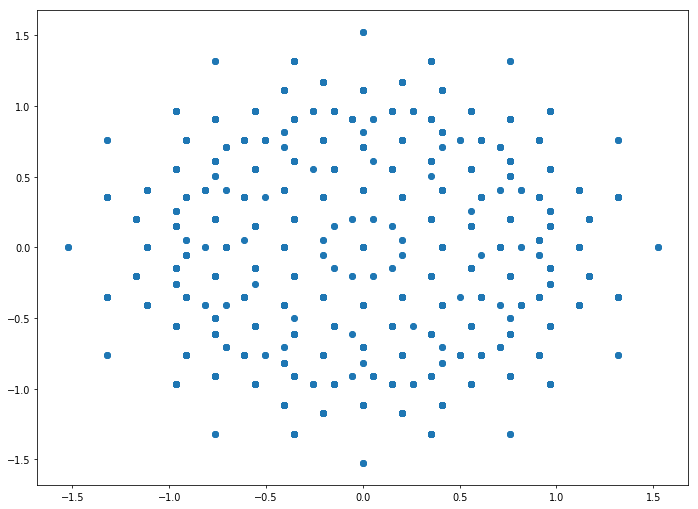

In [7]:
plt.scatter(data_pca[:,0], data_pca[:,1]);

In [84]:
data = np.load('../data/chorales_vectors_12_8.npy')

variables = ['%d_%s'%(j,i) for j in range(8) for i in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']]
df = pd.DataFrame(columns=variables, data=data)

In [85]:
G = models.MarkovModel()
for v in variables:
    G.add_node(v)

for i, v in enumerate(variables):
    neighbors = [v]
    if 'B' not in v:
        try:
            neighbors.append(variables[i + 1])
        except IndexError:
            pass
    if 'C' not in v:
        try:
            neighbors.append(variables[i - 1])
        except IndexError:
            pass
    
    try:
        neighbors.append(variables[i + 12])
    except IndexError:
        pass
    if i - 12 >= 0:
        try:
            neighbors.append(variables[i - 12])
        except IndexError:
            pass
    for a, b in itertools.combinations(neighbors, 2):
        G.add_edge(a, b)
        
'''
for i, v in enumerate(variables):
    neighbors = [v]
    if 'B' not in v:
        try:
            neighbors.append(variables[i + 1])
        except IndexError:
            pass
    if 'C' not in v:
        try:
            neighbors.append(variables[i - 1])
        except IndexError:
            pass
    
    try:
        neighbors.append(variables[i + 12])
    except IndexError:
        pass
    if i - 12 >= 0:
        try:
            neighbors.append(variables[i - 12])
        except IndexError:
            pass
    
    f = discrete.DiscreteFactor(
        neighbors,
        cardinality=[2] * len(neighbors),
        values=np.ones(2 ** len(neighbors))
    )
    G.add_factors(f)

for f in G.factors:
    for v, var2 in itertools.combinations(f.variables, 2):
        if var2 not in G.neighbors(v):
            print(v)
            print(G.neighbors(v))
            print(f)
            print(v, var2)
'''

G.check_model()

True

In [18]:
bm = G.to_bayesian_model()

MemoryError: 

In [15]:
bm.fit(df[:10])

AttributeError: 'FactorGraph' object has no attribute 'fit'

In [20]:
data.shape

(8184, 96)

In [3]:
data = np.load('../data/chorales_matrices_12_8.npy')

subdivisions = 8

stb_data = []

for data_point in range(data.shape[2]):
    m = data[:, :, data_point]
    notes = np.vstack(m.nonzero())
    new = notes[:, np.lexsort(notes)]
    voices = tuple(([] for _ in range(subdivisions)))
    for note, idx in new.T:
        voices[idx].append(note)

    stb = np.zeros((subdivisions, 3)).astype(np.int)
    for i, vcs in enumerate(voices):
        stb[i, 0] = vcs[0]
        stb[i, 1] = vcs[len(vcs) // 2]
        stb[i, 2] = vcs[-1]

    stb_data.append(stb.T.ravel())

In [4]:
variables = ['%d_%s'%(j,i) for i in ['B', 'T', 'S'] for j in range(subdivisions)]
df = pd.DataFrame(columns=variables, data=np.array(stb_data))
df[1:3]

,0_B,1_B,2_B,3_B,4_B,5_B,6_B,7_B,0_T,1_T,...,6_T,7_T,0_S,1_S,2_S,3_S,4_S,5_S,6_S,7_S
1,0,2,2,0,0,2,2,0,5,5,...,5,5,9,10,10,10,10,10,10,9
2,0,2,2,2,4,0,4,0,5,5,...,7,5,9,10,10,10,10,10,10,9


In [5]:
G = models.MarkovModel()
for v in variables:
    G.add_node(v)
# Set up the time-wise connections
for i in range(subdivisions - 1):
    G.add_edge('%d_S'%i, '%d_S'%(i+1))
    #G.add_edge('%d_T'%i, '%d_T'%(i+1))
    #G.add_edge('%d_B'%i, '%d_B'%(i+1))

for i in range(subdivisions):
    G.add_edge('%d_B'%i, '%d_T'%i)
    G.add_edge('%d_T'%i, '%d_S'%i)

G.check_model()

True

In [6]:
bm = G.to_bayesian_model()

In [7]:
bm.fit(df, state_names={i:list(range(12)) for i in variables})

In [9]:
df_idea = pd.DataFrame(columns=[i for i in variables if 'B' in i or 'T'], data=np.array([[0, 2, 4, 5, 4, 2, 0, 2]]).astype(np.int))
df_idea

,0_B,1_B,2_B,3_B,4_B,5_B,6_B,7_B
0,0,2,4,5,4,2,0,2
